In [3]:
from scipy.stats import gamma
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
import pickle as pkl
from kde_estimator import *

## Remeberance Index Algorithm
##### Almot any videos experience popularity decay after first publishment, either fast or slow. Classic masterpieces can be remebered quite long, whereas crude pieces will be forgot very quickly after first published. There's another way to interpret this, from recommendation algorithms' perspective - the longevity of a video can be measured by how likely the recommendation system is still willing to recommand this video after certain period of time. 

##### Following the heuristic that the most ideal but hypothetical classical art pieces never gets forgotten, that is, it recommandation likelihood does not decay with time, whereas a crude video will be forget serveral days after first publication, we can invent a curve looks like the figure below to measure the remeberance decay through time. 

##### Regarding how could we measure a video's degree of classicness, we propose to employ a video's percentile of view per day (vpd) of the video. For the sake of unbaisness (very old videos published before 2016 has very low user basis, so directly dividing the total video counts of a very old by its existing dates does not make sense), we cap the existing days to 6 * 365 (2015).  

In [17]:
def remeberance_index(x, vpd_percentile):
    """
    :param x: time since publication. Range from 0 to 1, inclusively.
        0 will be the first day of publication, 1 will be the day running this alogrithm.
    :param vpd_percentile: as with scale of 100. e.g. 49% input 49 
    """
    vpd_percentile = max(0.001, vpd_percentile)
    return (10 / (vpd_percentile / 10)) ** (-12 * x)

# def shifted_remeberance_index(x, vpd_percentile):
#     """
#     :param x: time since publication. Range from 0 to 1, inclusively.
#         0 will be the first day of publication, 1 will be the day running this alogrithm.
#     :param vpd_percentile: as with scale of 100. e.g. 49% input 49 
#     """
#     vpd_percentile = max(0.001, vpd_percentile)
#     return (10 / (vpd_percentile / 10)) ** (-12 * x)

In [18]:
xs = np.arange(0, 1, 0.001)

ri100 = remeberance_index(xs, 100)
ri95 = remeberance_index(xs, 95)
ri90 = remeberance_index(xs, 90)
ri50 = remeberance_index(xs, 50)
ri10 = remeberance_index(xs, 10)
ri0 = remeberance_index(xs, 0)

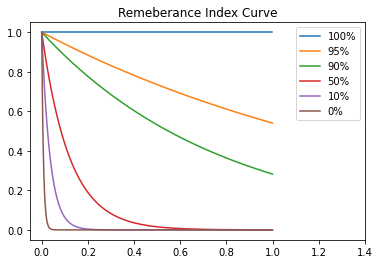

In [19]:
a, = plt.plot(xs, ri100, label="100%")
b, = plt.plot(xs, ri95, label="95%")
c, = plt.plot(xs, ri90, label="90%")
d, = plt.plot(xs, ri50, label="50%")
e, = plt.plot(xs, ri10, label="10%")
f, = plt.plot(xs, ri0, label="0%")
plt.title("Remeberance Index Curve")
plt.xticks(np.arange(0, 1.5, 0.2))
plt.legend(handles=[a,b,c,d,e,f])

## Bili Historical Popularity Tendency Curve (HPTC)
##### This curve fits the population variation tendency from the establishment date (06/26/2009) all the way to the point where this curve was first fit (04/01/2021). Bilibili experienced exponential growth of active users since 2016-2017 (around 0.6 in the below), slow growth in before 2016, and decelerated growth since 2020 (around 0.9 in the figure below)  since there are only 0.4 billion youngsters in China. This curve aims to serve as a stimulation for the overall growth of video view counts due to the absolute increment of total population. 

Reference https://www.bilibili.com/read/cv614761/

In [20]:
def historical_popularity_tendency(x):
    """
    :param x: the time point at which observation is made.
        range from 0 to infinity, where 0 stands for 06/26/2009 - bili establish date
        and 1 stands for 01/04/2021, where this curve was fitted.
        Notice in this function 0 and 1 has a invariant significance!
    """
    return 1 / (1 + np.exp(-8 * (x - 0.75)))
    

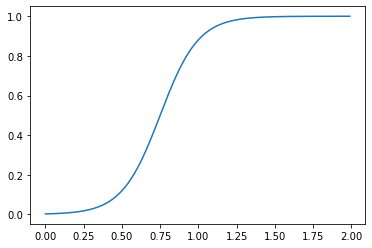

In [21]:
xs = np.arange(0, 2, 0.01)
plt.plot(xs, historical_popularity_tendency(xs))

 ## Long-term Video Popularity Variation (LVPV)
 ## This is the kernel we will use in our KDE!!!
 ### LVPV  = Shifted_RI * HPTC
 ### where Shifted_RI represents min-max scaled RI curve, as range of RI and HPTC has different meaning (0 in RI represents video publication date, where 0 in HPTC represents 06/26/2009).
 #### If a video happens to publish in 2009/06/26 and someone happens to run the algorithm at 04/01/2021, then every point on the range of HPTC and RI will overlap, and the production result looks like below:

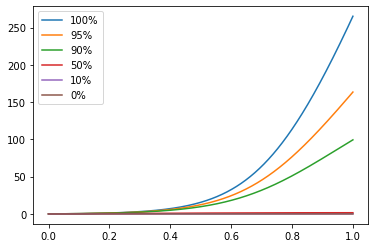

In [22]:
xs = np.arange(0, 1, 0.001)
hptc = historical_popularity_tendency(xs)
a, = plt.plot(xs, np.cumsum(hptc * ri100), label="100%")
b, = plt.plot(xs, np.cumsum(hptc * ri95), label="95%")
c, = plt.plot(xs, np.cumsum(hptc * ri90), label="90%")
d, = plt.plot(xs, np.cumsum(hptc * ri50), label="50%")
e, = plt.plot(xs, np.cumsum(hptc * ri10), label="10%")
f, = plt.plot(xs, np.cumsum(hptc * ri0), label="0%")
plt.legend(handles=[a,b,c,d,e,f])

### We can confirm this algorithms validity by comparing the real historical data of a 镇站之宝 (~corrected vpd 95th percentile).
##### Here's one of such videos: https://www.bilibili.com/video/BV1xx411c7mu?from=search&seid=12371597306738312429
##### The real popularity variation curve can be found at  https://www.biliob233.com/video/av106/info
##### Compare it with the model -- pretty close huh? 

## Caculating monthly view counts
##### The area under curve of LVPV will correspond to the total view counts. We can take integral from the range of the starting and ending month, and proportinoally take total view counts. Thanks to scipy, we don't need to estimate the integration results with numerical methods from scratch.

57.6


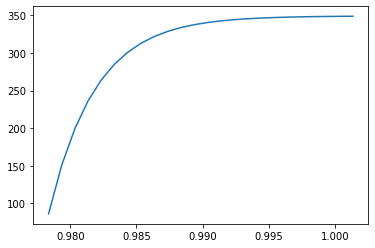

In [41]:
with open("./美食.pkl", "rb+") as file:
    # uploaed on Dec 29, 2020
    # ground truth ： https://www.biliob233.com/video/av458284617/history
    search_result_video_info = pkl.load(file)
    bv = "185411H7cb"
    bv2vpd = calc_corrected_vpd(search_result_video_info)
    bv2percentile = calc_vpd_percentile(bv2vpd)
    print(bv2percentile[bv])
    lvpv = construct_lvpv_curve(bv, search_result_video_info, bv2percentile)
    start = search_result_video_info[bv]["upload_date"]
    end = NOW
    start_htpc = min_max_scale_date_hptc(start)
    end_htpc = min_max_scale_date_hptc(end)
    xs = np.arange(start_htpc, end_htpc, 0.001)
    ys = lvpv(xs)
    plt.plot(xs, np.cumsum(ys))